# Step-by-Step Advanced Lane Detection algorithm 

In this notebook we are going to make a walkthrough in the Advanced lane detection algorithm: 

[1. Choosing a region of interest (ROI)](#step1)

[2. Transform the ROI in a bird's eye view](#step2)

[3. Lane segmentation](#step3)

[4. Find the beggining of each lane](#step4)

[5. Find the entire lane using sliding windows](#step5)

[6. Fit a polynomial equation to the detected lane](#step6)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

<a id='step1'></a>
## 1. Choosing a region of interest (ROI)

#### 1.1 Loading test images 

In [2]:
# We have 12 jpg test images in the test_images folder 
# attention: The images were saved in the BGR format and have H = 480 and W = 640
def ReadImages():
    images = []
    for i in range(13):
        img = cv2.cvtColor(cv2.imread("test_images/"+str(i)+".jpg"), cv2.COLOR_BGR2RGB)
        images.append(img)
    
    return images

In [3]:
images = ReadImages()

In [4]:
original_image = images[0]

#### 1.2 Define our ROI 

In [5]:
def drawROI(originalImage, roi):
    left = roi[0]
    right = roi[1]
    apex_left = roi[2]
    apex_right = roi[3]
    
    return cv2.polylines(originalImage,np.int32(np.array([[left,apex_left,apex_right,right]])),True,(0,0,255),10)

In [6]:
# These points were chosen by hand
roi = [[0,300], [639, 300], [150, 140], [450, 140]]

In [7]:
roi_image = drawROI(original_image.copy(), roi)

Text(0.5, 1.0, 'ROI')

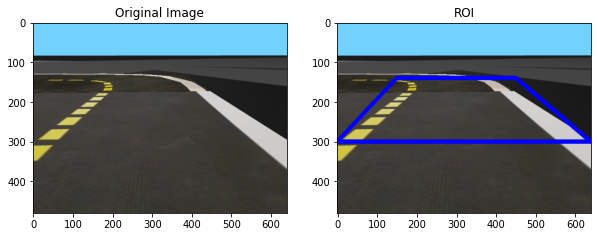

In [8]:
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot(1,2,1)
ax1.imshow(original_image)
ax1.set_title("Original Image")

ax2 = plt.subplot(1,2,2)
ax2.imshow(roi_image)
ax2.set_title("ROI")

<a id="step2"></a>
## 2. Transform the ROI in a bird's eye view 

In [9]:
def getTransform(roi, dst_points):
    left = roi[0]
    right = roi[1]
    apex_left = roi[2]
    apex_right = roi[3]

    src = np.float32([left, apex_left, apex_right, right])
    dst = np.float32(dst_points)
    
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return M, M_inv

def WarpPerspective(image, M):
    return cv2.warpPerspective(image, M, (image.shape[0], image.shape[1]), flags=cv2.INTER_AREA)

2.1 First, we need to define our destination points (also chose by hand). These destinations points will be used to generate a matrix transformation that will map our image to a bird's eye view one. Once we have this matrix, we can call warp perspective to apply the transform. 

In [10]:
dst_points = [[100, 479], [100,0], [400,0], [400,479]]

In [11]:
M, M_inv = getTransform(roi, dst_points)

In [12]:
bird_image = WarpPerspective(original_image.copy(), M)

Text(0.5, 1.0, "Bird's eye view")

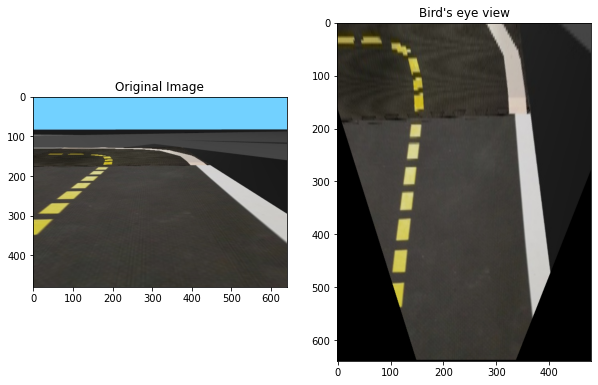

In [13]:
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot(1,2,1)
ax1.imshow(original_image)
ax1.set_title("Original Image")

ax2 = plt.subplot(1,2,2)
ax2.imshow(bird_image)
ax2.set_title("Bird's eye view")

<a id="step3"></a>
## 3. Lane Segmentation 

In [14]:
def toHSV(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

def imageThreshold(image, threshold):
    low = threshold[0]
    high = threshold[1]
    return cv2.inRange(image, low, high)

def segmentYellowLane(image):
    return cv2.inRange(image, (20, 50, 100), (30, 255, 255))

In [15]:
yellow_threshold = [(20, 50, 100), (30, 255, 255)]
white_threshold = [(0, 0, 160), (255, 40, 255)]

hsv_bird_image = toHSV(bird_image.copy())

In [16]:
yellow_binary = imageThreshold(hsv_bird_image.copy(), yellow_threshold)
white_binary = imageThreshold(hsv_bird_image.copy(), white_threshold)

Text(0.5, 1.0, 'Yellow and white thresholds combined')

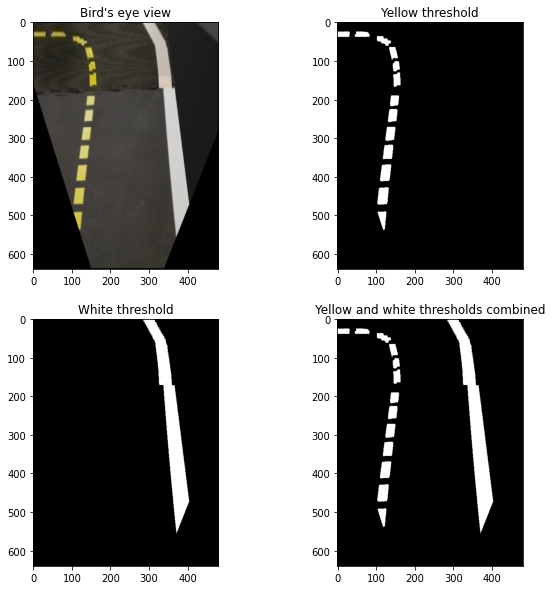

In [17]:
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot(2,2,1)
ax1.imshow(bird_image)
ax1.set_title("Bird's eye view")

ax2 = plt.subplot(2,2,2)
ax2.imshow(yellow_binary, cmap="gray")
ax2.set_title("Yellow threshold")

ax3 = plt.subplot(2,2,3)
ax3.imshow(white_binary, cmap="gray")
ax3.set_title("White threshold")

ax4 = plt.subplot(2,2,4)
ax4.imshow(cv2.bitwise_or(yellow_binary, white_binary), cmap="gray")
ax4.set_title("Yellow and white thresholds combined")

<a id="step4"></a>
## 4. Find the beggining of each lane 

In [18]:
def findFirstWindow(w_x, w_y, w_height, w_width, nonzero_x, nonzero_y, debug=False):
    
    dict_first_window = {}
    if debug:
        dict_first_window["w_centroids"] = []
    
    done = False
    dict_first_window["found"] = False
    
    while not done:
        if debug:
            dict_first_window["w_centroids"].append([w_x,w_y])

        w_x_high = int(w_x - w_width/2)
        w_y_high = int(w_y - w_height/2)

        w_x_low = int(w_x + w_width/2)
        w_y_low = int(w_y + w_height/2)

        if w_x_high < 0 or w_x_low > 480 or w_y_high < 0 or w_y_low > 640:
            done = True
            continue
        
        inside_window = ( (nonzero_y >= w_y_high) & (nonzero_y < w_y_low) & 
            (nonzero_x >= w_x_high) &  (nonzero_x <= w_x_low)).nonzero()[0]

        if len(inside_window) > min_pix:
            w_x = int(np.mean(nonzero_x[inside_window]))
            w_y = int(np.mean(nonzero_y[inside_window]))
            
            if debug:
                dict_first_window["w_centroids"].append([w_x, w_y])

            done = True
            dict_first_window["found"] = True
            dict_first_window["w_center"] = (w_x, w_y)
        else:
            w_y = int(w_y - w_height)
            dict_first_window["w_centroids"].append([w_x, w_y])
            
    return dict_first_window

In [19]:
def debugInitialWindow(image, initial_centroids, w_width, w_height):
    initial_window_img = np.dstack((image, image, image))

    for window in initial_centroids[:-1]:
        w_x_high = int(window[0] - w_width/2)
        w_y_high = int(window[1] - w_height/2)

        w_x_low = int(window[0] + w_width/2)
        w_y_low = int(window[1] + w_height/2)

        initial_window_img = cv2.rectangle(initial_window_img, (w_x_high, w_y_high), (w_x_low, w_y_low), (255,255,0), 5)

    window = initial_centroids[-1]
    w_x_high = int(window[0] - w_width/2)
    w_y_high = int(window[1] - w_height/2)

    w_x_low = int(window[0] + w_width/2)
    w_y_low = int(window[1] + w_height/2)

    initial_window_img = cv2.rectangle(initial_window_img, (w_x_high, w_y_high), (w_x_low, w_y_low), (255,0,0), 5)
    
    return initial_window_img

4.1 We assume that the lanes are for its majority verticals, so we compute an histogram summing along all the colums of the image. The position with the highest value is the position that we will start searching. 

In [20]:
yellow_hist = np.sum(yellow_binary, axis=0)
white_hist = np.sum(white_binary, axis=0)

Text(0.5, 1.0, 'Histogram for white lane')

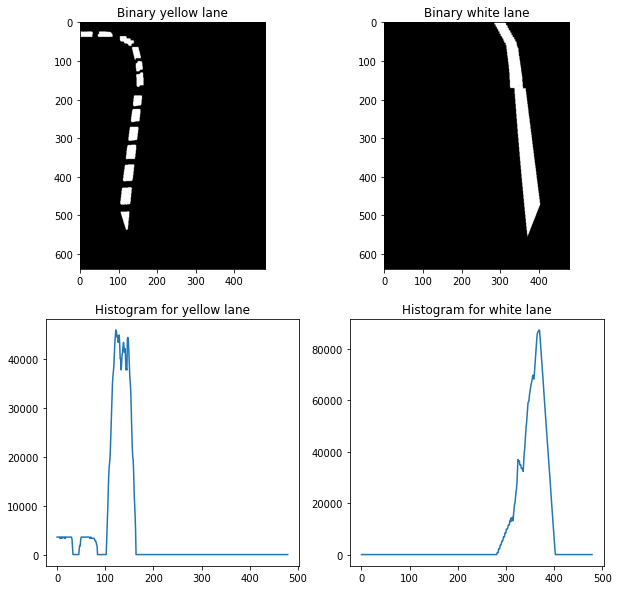

In [21]:
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot(2,2,1)
ax1.imshow(yellow_binary, cmap="gray")
ax1.set_title("Binary yellow lane")

ax2 = plt.subplot(2,2,2)
ax2.imshow(white_binary, cmap="gray")
ax2.set_title("Binary white lane")

ax3 = plt.subplot(2,2,3)
ax3.plot(yellow_hist)
ax3.set_title("Histogram for yellow lane")

ax4 = plt.subplot(2,2,4)
ax4.plot(white_hist)
ax4.set_title("Histogram for white lane")

4.2 Get all the positions of the pixels in either binary image that are not zero and start searching the first first window that contains the lane. For that, we must define a window size and then we apply vertical offsets, starting from the x position that has the highest value in the histogram, and we count how many nonzero pixels are inside of the window, if this number is superior to a threshold we found the first window of the lane.

In [22]:
w_height = 30
w_width = 40

min_pix = 100

4.2.1 Yellow 

In [23]:
nonzero_yellow = yellow_binary.nonzero()
nonzero_y_yellow = np.array(nonzero_yellow[0])
nonzero_x_yellow = np.array(nonzero_yellow[1])


w_x = int(np.argmax(yellow_hist))
w_y = int(yellow_binary.shape[0] - w_height/2)

In [24]:
yellow_dict_first_window = findFirstWindow(w_x, w_y, w_height, w_width, nonzero_x_yellow, nonzero_y_yellow, debug=True)
yellow_initial_window_image = debugInitialWindow(yellow_binary.copy(), yellow_dict_first_window["w_centroids"], w_width, w_height)

4.2.2 White 

In [25]:
nonzero_white = white_binary.nonzero()
nonzero_y_white = np.array(nonzero_white[0])
nonzero_x_white = np.array(nonzero_white[1])


w_x = int(np.argmax(white_hist))
w_y = int(white_binary.shape[0] - w_height/2)

In [26]:
white_dict_first_window = findFirstWindow(w_x, w_y, w_height, w_width, nonzero_x_white, nonzero_y_white, debug=True)
white_initial_window_image = debugInitialWindow(white_binary.copy(), white_dict_first_window["w_centroids"], w_width, w_height)

Text(0.5, 1.0, 'First window white lane')

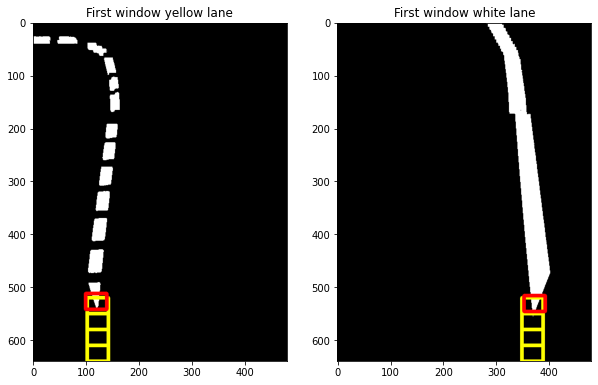

In [27]:
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot(1,2,1)
ax1.imshow(yellow_initial_window_image)
ax1.set_title("First window yellow lane")

ax2 = plt.subplot(1,2,2)
ax2.imshow(white_initial_window_image)
ax2.set_title("First window white lane")

<a id="step5"></a>
## 5. Find the entire lane using sliding windows

In [28]:
def findRemainingWindows(w_center, w_height, w_width, nonzero_x, nonzero_y, debug=False):
    offsets = [(-w_width, 0), (-w_width, -w_height), (0, -w_height), (w_width, w_height), (w_width, 0)] #left, upper-left, above, uper right, right
    
    dict_remaining_w = {}
    
    if debug:
        dict_remaining_w["search_windows"] = []
    dict_remaining_w["chosen_windows"] = []
    dict_remaining_w["inside_points"] = []
    
    current_x = w_center[0]
    current_y = w_center[1]
    
    done = False
    count = 0
    while not done and (count < 30):
        best_offset_index = -1
        best_offset_p = -1
        best_inside_indexes = None
        
        for i, off in enumerate(offsets):
            w_x = current_x + off[0]
            w_y = current_y + off[1]

            w_x_high = int(w_x - w_width/2)
            w_y_high = int(w_y - w_height/2)

            w_x_low = int(w_x + w_width/2)
            w_y_low = int(w_y + w_height/2)

            if w_x_high < 0 or w_x_low > 480 or w_y_high < 0 or w_y_low > 640:
                pixels_inside = 0
                inside_window = None
            else:
                inside_window = ( (nonzero_y >= w_y_high) & (nonzero_y < w_y_low) & 
            (nonzero_x >= w_x_high) &  (nonzero_x <= w_x_low)).nonzero()[0]
                pixels_inside = len(inside_window)

                if debug:
                    dict_remaining_w["search_windows"].append((w_x,w_y))
            
            if pixels_inside > best_offset_p:
                best_offset_index = i
                best_offset_p = pixels_inside
                best_inside_indexes = inside_window

        if best_offset_p <= 0:
            done = True
        else:
            current_x = int(np.mean(nonzero_x[best_inside_indexes]))
            current_y = int(np.mean(nonzero_y[best_inside_indexes]))
            dict_remaining_w["inside_points"].append(best_inside_indexes)
            if len(dict_remaining_w["chosen_windows"]) > 0 and current_x == dict_remaining_w["chosen_windows"][-1][0] and current_y == dict_remaining_w["chosen_windows"][-1][1]:
                done = True
            #print(current_x, current_y)
            dict_remaining_w["chosen_windows"].append((current_x,current_y))
        
        count += 1
    #print(done, count)
    return dict_remaining_w

In [29]:
def debugRemainingWindows(img, dict_remaining_windows, w_height, w_width):
    remaining_windows_img = np.dstack((img, img, img))

    for window in dict_remaining_windows["search_windows"]:
        w_x_high = int(window[0] - w_width/2)
        w_y_high = int(window[1] - w_height/2)

        w_x_low = int(window[0] + w_width/2)
        w_y_low = int(window[1] + w_height/2)

        remaining_windows_img = cv2.rectangle(remaining_windows_img, (w_x_high, w_y_high), (w_x_low, w_y_low), (255,255,0), 5)

    for window in dict_remaining_windows["chosen_windows"]:
        w_x_high = int(window[0] - w_width/2)
        w_y_high = int(window[1] - w_height/2)

        w_x_low = int(window[0] + w_width/2)
        w_y_low = int(window[1] + w_height/2)

        remaining_windows_img = cv2.rectangle(remaining_windows_img, (w_x_high, w_y_high), (w_x_low, w_y_low), (255,0,0), 5)

    return remaining_windows_img   

5.1 Here we will use the first window position to start our lane search. From that position we use a set of window offsets and look which offset leads to more pixels inside the window, this window with more pixels inside will be the new start for the next window. We repeat this procedure until we don't change our window position or we pass the boundaries of the image or we reach 30 repetitions. 

5.1.1 Yellow

In [30]:
yellow_dict_remaining_windows = findRemainingWindows(yellow_dict_first_window["w_center"], w_height, w_width, nonzero_x_yellow, nonzero_y_yellow, debug=True)
yellow_dict_remaining_windows["chosen_windows"] = [yellow_dict_first_window["w_center"]] + yellow_dict_remaining_windows["chosen_windows"]
yellow_lane_windows = debugRemainingWindows(yellow_binary.copy(), yellow_dict_remaining_windows, w_height, w_width)

5.1.2 White 

In [31]:
white_dict_remaining_windows = findRemainingWindows(white_dict_first_window["w_center"], w_height, w_width, nonzero_x_white, nonzero_y_white, debug=True)
white_dict_remaining_windows["chosen_windows"] = [white_dict_first_window["w_center"]] + white_dict_remaining_windows["chosen_windows"]
white_lane_windows = debugRemainingWindows(white_binary.copy(), white_dict_remaining_windows, w_height, w_width)

Text(0.5, 1.0, 'White lane search and chosen windows')

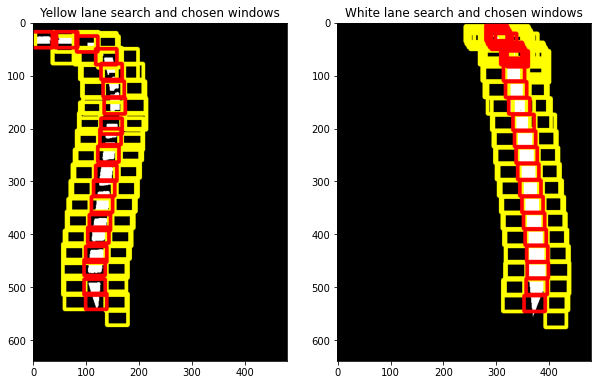

In [32]:
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot(1,2,1)
ax1.imshow(yellow_lane_windows)
ax1.set_title("Yellow lane search and chosen windows")

ax2 = plt.subplot(1,2,2)
ax2.imshow(white_lane_windows)
ax2.set_title("White lane search and chosen windows")

<a id="step6"></a>
## 6. Fit a polynomial equation to the detected lane 

6.1 Finally, once we have our detection windws, we fit a polynomial equation of 3° degree to the points inside the windows. 

6.1.1 Yellow 

In [33]:
yellow_all_idexes = np.concatenate(yellow_dict_remaining_windows["inside_points"])
yellow_all_points_x = nonzero_x_yellow[yellow_all_idexes]
yellow_all_points_y = nonzero_y_yellow[yellow_all_idexes]
yellow_fit = np.polyfit(yellow_all_points_y, yellow_all_points_x, 3)

6.1.2 White 

In [34]:
white_all_idexes = np.concatenate(white_dict_remaining_windows["inside_points"])
white_all_points_x = nonzero_x_white[white_all_idexes]
white_all_points_y = nonzero_y_white[white_all_idexes]
white_fit = np.polyfit(white_all_points_y, white_all_points_x, 3)

In [35]:
warped_zeros = np.zeros_like(bird_image)

yellow_curve_points_x = (yellow_fit[0]*yellow_all_points_y**3 + yellow_fit[1]*yellow_all_points_y**2 + yellow_fit[2]*yellow_all_points_y + yellow_fit[3]).astype(np.int32)
yellow_pts = np.flipud(np.transpose(np.vstack([yellow_curve_points_x, yellow_all_points_y])))
warped_binary_lanes = cv2.polylines(warped_zeros, np.int_([yellow_pts]), isClosed=False, color=(255,0,0), thickness = 20)

white_curve_points_x = (white_fit[0]*white_all_points_y**3 + white_fit[1]*white_all_points_y**2 + white_fit[2]*white_all_points_y + white_fit[3]).astype(np.int32)
white_pts = np.flipud(np.transpose(np.vstack([white_curve_points_x, white_all_points_y])))
warped_binary_lanes = cv2.polylines(warped_zeros, np.int_([white_pts]), isClosed=False, color=(0,0,255), thickness = 20)

original_binary_lanes = WarpPerspective(warped_binary_lanes.copy(), M_inv)

Text(0.5, 1.0, 'Original image + detected lanes')

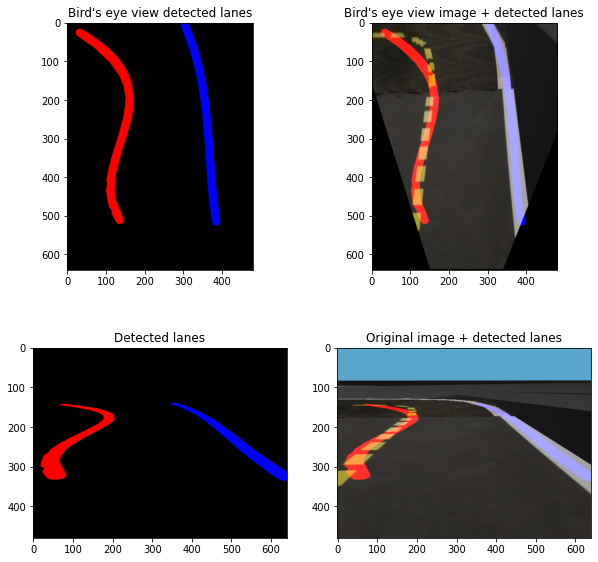

In [36]:
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot(2,2,1)
ax1.imshow(warped_binary_lanes)
ax1.set_title("Bird's eye view detected lanes")

ax2 = plt.subplot(2,2,2)
ax2.imshow(cv2.addWeighted(warped_binary_lanes, 1.0, bird_image, 0.8, 0.0))
ax2.set_title("Bird's eye view image + detected lanes")

ax3 = plt.subplot(2,2,3)
ax3.imshow(original_binary_lanes)
ax3.set_title("Detected lanes")

ax4 = plt.subplot(2,2,4)
ax4.imshow(cv2.addWeighted(original_binary_lanes, 1.0, original_image, 0.8, 0.0))
ax4.set_title("Original image + detected lanes")